<h1>Scrapping Amazon Beset Selling Electronics Data</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import textwrap

<h3> To web scrape the HTML document follow following steps:</h3>
    <ol>
        <li>Define a <b>get_data()</b>function which will input the page numbers as an argument</li>
        <li>Define a <b>headers</b> which will help in bypassing the detection as a scraper</li>
        <li>Specify the <b>URL</b> to requests.get() function and pass the headers variable as an argument</li>
        <li>Extract the response by requests.get(). It could be text or content.</li>
        <li>Scrape the specified page and assign it to <b>soup</b> variable</li>
        <li> All the pages we want to scrape have the same overall structure. This implies that they also have the same overall HTML structure. So, to write our script, it will suffice to understand the HTML structure of only one page. If you use Chrome, right-click on a web page element that interests you, and then click Inspect. This will take you right to the HTML line that corresponds to that element. Next step is to identify the parent tag under which all the data you need will reside. There are a lot of HTML lines nested within div/span tag. You can explore HTML lines corresponding to each div/span.</li>
        <li>There are many products shown per page, so there should be a div/span/li <b>container</b> for each. Before extracting these containers, we need to figure out what distinguishes them from other elements on that page. Often, the distinctive mark resides in the <b>class</b> attribute. Use the find_all() method to extract all the 'li' containers that have a class attribute 'zg-item-immersion'. <b>find_all()</b> returned a result set ('d') object which is a list containing all the containers we are interested in.</li>
        <li> Now select only the first container, and extract, by turn, each item of interest:
        <ul>
        <li>Name of the product</li>
        <li>Rating</li>
        <li>Customer Rated</li>
        <li>Price</li>
        </ul>
        </li>
    </ol>

In [2]:
#number of web pages you want to scrape
no_pages=2

def get_data(pageNo):
    # To get header information of your browser. Follow the following steps:  
    # (1) Visit a URL, right click, select Inspect to open the developer tools.
    # (2) Select Network tab
    # (3) Reload the page, select any HTTP request on the left panel i.e. Name, and the HTTP headers will be displayed on the right panel.
    headers={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/        *;q=0.8,application/signed-exchange;v=b3;q=0.9", 
        "Accept-Encoding": "gzip, deflate, br", 
        "Upgrade-Insecure-Requests": "1", 
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)             Chrome/87.0.4280.88 Safari/537.36", 
    }
    
    # Requesting content of a website:
    # (1) Import requests module.
    # (2) Pass the address of the web page to get() function. 
    # (3) get() function will request the server the content of the web page, and store the server’s                 response in the variable response 'r'.
    # requests.Response 'r' has following attributes:
    # (a) r.text is the content of the response in Unicode, and 
    # (b) r.content is the content of the response in bytes.
    # we want the response in byte format. 
    
    r=requests.get('https://www.amazon.com/Best-Sellers-Electronics/zgbs/electronics/ref=zg_bs_pg_'+str(pageNo)+'?_encoding=UTF8&pg='+str(pageNo), headers=headers)

    # Parse HTML document using beautifulSoup
    # (1) Import the BeautifulSoup class creator from the package bs4.
    # (2) Parse response.content by creating a BeautifulSoup object, and assign this object to soup. The 'html.parser' argument indicates that we want to do the parsing using Python’s built-in HTML parser.

    content=r.content
    soup= BeautifulSoup(content, 'html.parser')

    alls=[]
    for d in soup.findAll('li', attrs={'class':'zg-item-immersion'}):
        name=d.find('span',attrs={'class':'zg-text-center-align'})
        n=name.find_all('img',alt=True)
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated=d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price=d.find('span',attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is not None:
            all1.append(n[0]['alt'])
        else:
            all1.append("unknown-product")

        if rating is not None:
            all1.append(rating.text)
        else:
            all1.append('-1')

        if users_rated is not None:
            all1.append(users_rated.text)
        else:
            all1.append('0')

        if price is not None:
            all1.append(price.text)
        else:
            all1.append('0')
        alls.append(all1)
    return alls

In [3]:
results=[]
for i in range(1,no_pages+1):
    results.append(get_data(i))

flatten=lambda l:[item for sublist in l for item in sublist]
df=pd.DataFrame(flatten(results),columns=['Product_Name','Rating','Customer_Rated','Price'])

df.to_csv('amazon_products.csv',index=False, encoding='utf-8')

In [4]:
df_amazon=pd.read_csv('amazon_products.csv')
df_amazon.head()

,Product_Name,Rating,Customer_Rated,Price
0,Fire TV Stick 4K streaming device with Alexa V...,4.7 out of 5 stars,"503,520",$49.99
1,Echo Show 5 -- Smart display with Alexa – stay...,4.6 out of 5 stars,"285,894",$45.98
2,"All-new Echo Dot (4th Gen, 2020 release) | Sma...",4.7 out of 5 stars,"112,386",$59.99
3,Roku Express | HD Streaming Media Player with ...,4.8 out of 5 stars,"79,699",$28.88
4,"Fire 7 tablet (7"" display, 16 GB) - Black",4.4 out of 5 stars,"149,678",$82.97


In [5]:
df_amazon.dtypes

Product_Name      object
Rating            object
Customer_Rated    object
Price             object
dtype: object

In [6]:
df_amazon['Rating']=df_amazon['Rating'].apply(lambda x: x.split()[0])
df_amazon['Rating']=pd.to_numeric(df_amazon['Rating'])

In [7]:
df_amazon['Price']=df_amazon['Price'].str.replace('$', '')
df_amazon['Price']=df_amazon['Price'].astype(float)

In [8]:
df_amazon['Customer_Rated'] = df_amazon['Customer_Rated'].str.replace(',', '')
df_amazon['Customer_Rated']=pd.to_numeric(df_amazon['Customer_Rated'])

In [9]:
df_amazon.dtypes

Product_Name       object
Rating            float64
Customer_Rated      int64
Price             float64
dtype: object

In [10]:
df_amazon.head()

,Product_Name,Rating,Customer_Rated,Price
0,Fire TV Stick 4K streaming device with Alexa V...,4.7,503520,49.99
1,Echo Show 5 -- Smart display with Alexa – stay...,4.6,285894,45.98
2,"All-new Echo Dot (4th Gen, 2020 release) | Sma...",4.7,112386,59.99
3,Roku Express | HD Streaming Media Player with ...,4.8,79699,28.88
4,"Fire 7 tablet (7"" display, 16 GB) - Black",4.4,149678,82.97


In [11]:
count_nan = len(df_amazon) - df_amazon.count()

In [12]:
#data = df_amazon.sort_values(["User_Rating"], axis=0, ascending=False)
#data= df_amazon.query('User_Rating > 1000').nlargest(10,'User_Rating')
data_user_rating= df_amazon.nlargest(10,'Customer_Rated')
data_user_rating

,Product_Name,Rating,Customer_Rated,Price
0,Fire TV Stick 4K streaming device with Alexa V...,4.7,503520,49.99
1,Echo Show 5 -- Smart display with Alexa – stay...,4.6,285894,45.98
4,"Fire 7 tablet (7"" display, 16 GB) - Black",4.4,149678,82.97
85,"Fire HD 10 Tablet (10.1"" 1080p full HD display...",4.6,147213,0.00
16,Echo Show 8 -- HD smart display with Alexa – s...,4.7,146627,79.99
32,"Fire 7 Kids Edition Tablet, 7"" Display, 16 GB,...",4.6,139739,134.98
2,"All-new Echo Dot (4th Gen, 2020 release) | Sma...",4.7,112386,59.99
28,"Apple Watch Series 3 (GPS, 38mm) - Space Gray ...",4.8,103368,230.25
44,"Apple Watch Series 3 (GPS, 38mm) - Silver Alum...",4.8,103368,230.29
62,"Apple Watch Series 3 (GPS, 42mm) - Space Gray ...",4.8,103368,259.96


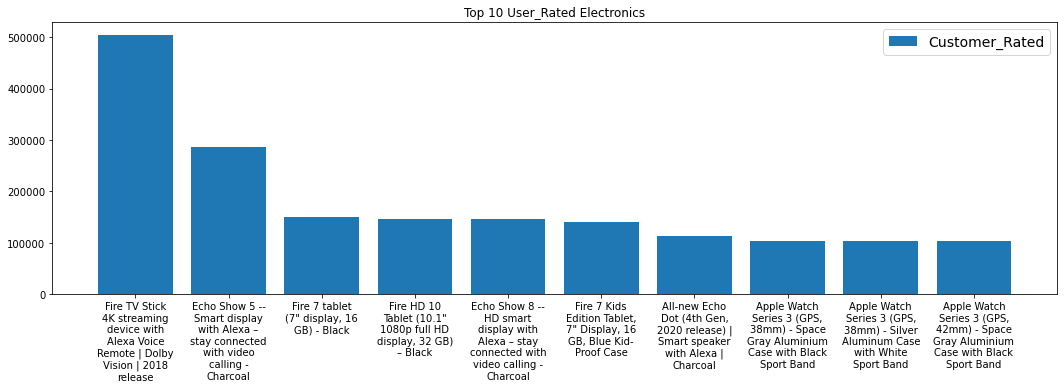

In [13]:
fig, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar([textwrap.fill(e, 15) for e in data_user_rating['Product_Name']], data_user_rating['Customer_Rated'], label = 'Customer_Rated')
ax.legend(fontsize=14)
ax.set_title('Top 10 User_Rated Electronics')
fig.show()